In [1]:
# Importing libraries
import os
import warnings
import pandas as pd
import numpy as np
import warnings
import itertools
from math import sqrt
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

import datetime
import time
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore") # specify to ignore warning messages


%matplotlib inline
plt.rcParams['figure.figsize']=(15,6) # set the figure size
plt.rcParams['lines.linewidth'] = 1

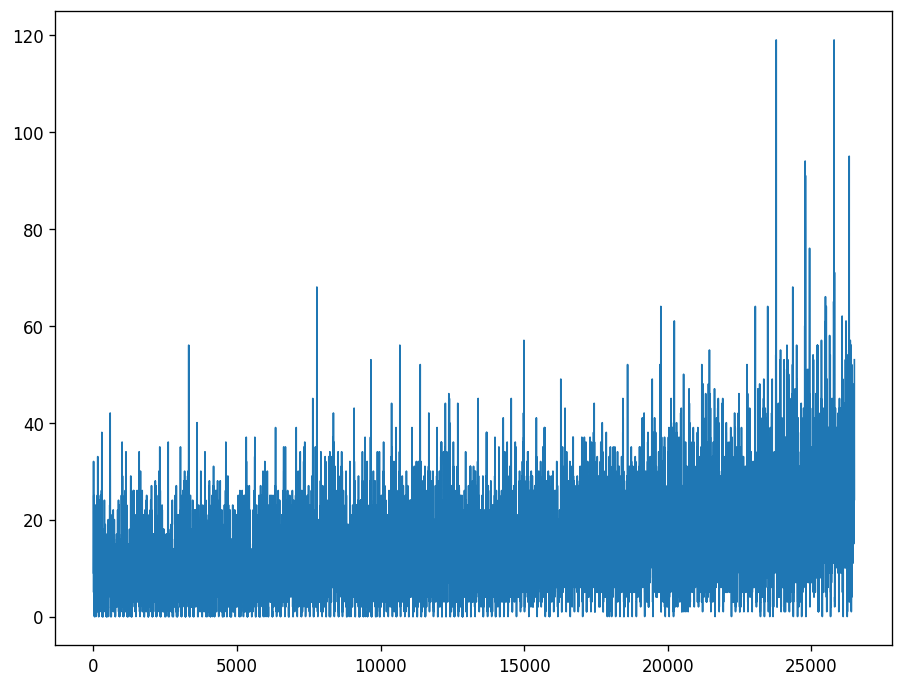

In [2]:
# load dataset
df = pd.read_csv('./data/taxi.csv')
df['DateTime'] = pd.to_datetime(df['datetime'])
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.plot(df.num_orders)

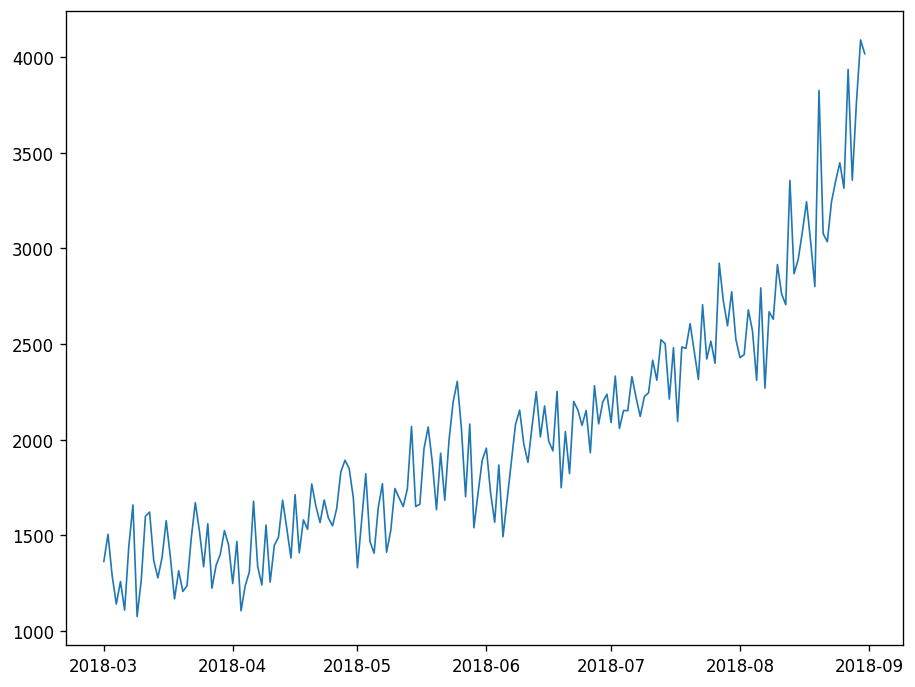

In [3]:
#convert the data to daily bookings to identify the trend in the bookings
data_daily = df.resample('24H', on='DateTime').sum()
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.plot(data_daily.num_orders)

# Data manipulation
convert the data from every 10 mins to every hour to predict the hourly bookings and then run few tests to identify the trend and seasonality in the data

In [4]:
data_hourly = df.resample('1H', on='DateTime').sum()

In [5]:
values = data_hourly.num_orders
# getting the count to split the dataset into 3
parts = int(len(values)/3)
 
# splitting the data into three parts
part_1, part_2, part_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean2=%f' % (mean_1, mean_2, mean_3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance2=%f' % (var_1, var_2, var_3))

mean1=60.539402, mean2=78.531250, mean2=114.197690
variance1=958.978732, variance2=1158.881416, variance2=2473.652938


In [6]:
# extracting only the passengers count using values function
values = data_hourly.num_orders
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -3.068924
p-value: 0.028940
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [7]:
data_hourly

,num_orders
DateTime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# Use AutoARIMA
To find the optimal p, q and d parameters for the model

In [10]:
import pmdarima as pm

model = pm.auto_arima(data_hourly.iloc[0:1440], start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=1,             
                      d=None,         
                      seasonal=True,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13556.559, Time=1.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13974.298, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13565.363, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13679.968, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16235.713, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13555.215, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13553.653, Time=0.61 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=13553.130, Time=0.56 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=13532.641, Time=0.60 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=13534.361, Time=0.76 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=13534.609, Time=1.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13541.267, Time=3.91 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=13536.355, Time=1.59 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=13765.922, Time=0.36 sec

Best model:  ARIMA

In [11]:
X = data_hourly.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)
for t in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=118.363598, expected=102.000000
predicted=172.899392, expected=175.000000
predicted=190.898533, expected=144.000000
predicted=128.427236, expected=152.000000
predicted=87.734679, expected=104.000000
predicted=111.971012, expected=91.000000
predicted=104.672746, expected=82.000000
predicted=126.559674, expected=160.000000
predicted=122.815383, expected=104.000000
predicted=181.186055, expected=134.000000
predicted=164.430592, expected=139.000000
predicted=214.466666, expected=231.000000
predicted=286.440808, expected=108.000000
predicted=93.594107, expected=190.000000
predicted=89.840065, expected=139.000000
predicted=38.854468, expected=47.000000
predicted=16.430698, expected=45.000000
predicted=10.952214, expected=54.000000
predicted=105.087839, expected=91.000000
predicted=124.362974, expected=135.000000
predicted=135.513498, expected=155.000000
predicted=123.437547, expected=162.000000
predicted=132.722920, expected=114.000000
predicted=138.707487, expected=64.000000
predi

predicted=74.813076, expected=93.000000
predicted=108.418449, expected=160.000000
predicted=146.965620, expected=105.000000
predicted=158.795077, expected=178.000000
predicted=186.112124, expected=240.000000
predicted=271.450885, expected=112.000000
predicted=287.964639, expected=197.000000
predicted=168.189681, expected=154.000000
predicted=184.836875, expected=127.000000
predicted=-2.718592, expected=76.000000
predicted=-26.691934, expected=80.000000
predicted=-3.429928, expected=68.000000
predicted=72.817825, expected=96.000000
predicted=110.412468, expected=136.000000
predicted=157.237562, expected=109.000000
predicted=148.625655, expected=114.000000
predicted=90.569171, expected=69.000000
predicted=77.850977, expected=119.000000
predicted=106.318059, expected=145.000000
predicted=173.044587, expected=92.000000
predicted=128.696268, expected=174.000000
predicted=128.995426, expected=184.000000
predicted=117.201413, expected=116.000000
predicted=136.581076, expected=121.000000
predi

predicted=179.609976, expected=217.000000
predicted=191.141285, expected=232.000000
predicted=200.022195, expected=193.000000
predicted=182.508531, expected=186.000000
predicted=114.577989, expected=56.000000
predicted=100.019074, expected=13.000000
predicted=88.430701, expected=39.000000
predicted=162.182204, expected=166.000000
predicted=167.118182, expected=226.000000
predicted=188.461360, expected=227.000000
predicted=175.185816, expected=156.000000
predicted=165.373600, expected=173.000000
predicted=148.239284, expected=154.000000
predicted=191.141748, expected=91.000000
predicted=171.121814, expected=156.000000
predicted=170.946064, expected=254.000000
predicted=195.931015, expected=342.000000
predicted=165.527437, expected=177.000000
predicted=191.140484, expected=72.000000
predicted=173.840072, expected=142.000000
predicted=214.021627, expected=198.000000
predicted=191.697740, expected=158.000000
predicted=218.875022, expected=246.000000
predicted=225.912627, expected=276.00000

NameError: name 'pyplot' is not defined

Test RMSE: 49.720


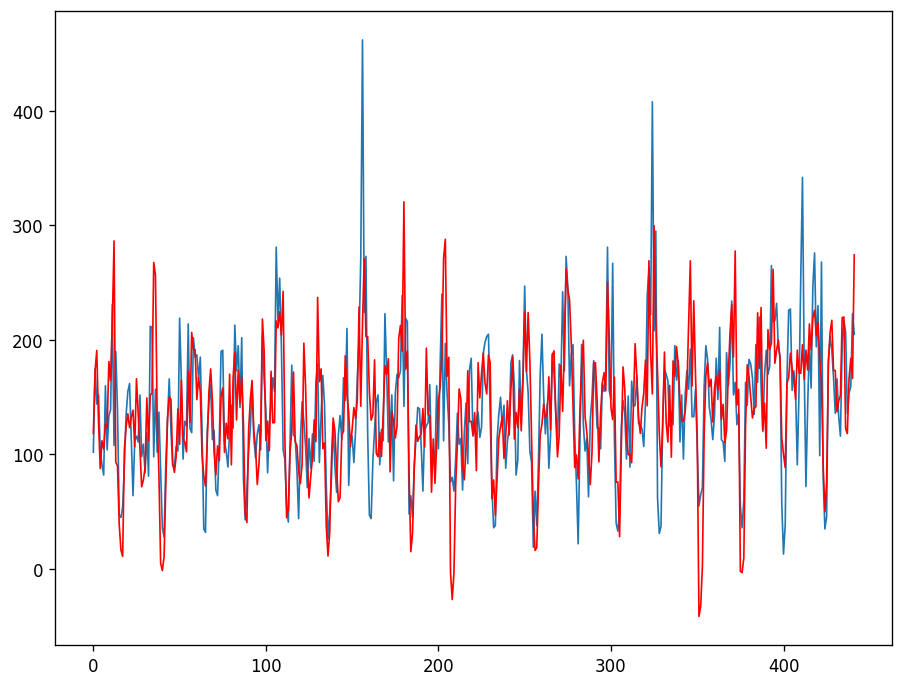

In [14]:
from matplotlib import pyplot
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()